## Get the output.manifest file

In [650]:
import boto3


JOBNAME = 'logo-2-clone-clone' #Replace it with the labeling job name


client = boto3.client('sagemaker',region_name='us-east-1')

response = client.describe_labeling_job(LabelingJobName= JOBNAME)
file = response['LabelingJobOutput']['OutputDatasetS3Uri']
response


{'LabelingJobStatus': 'Completed',
 'LabelCounters': {'TotalLabeled': 5,
  'HumanLabeled': 5,
  'MachineLabeled': 0,
  'FailedNonRetryableError': 0,
  'Unlabeled': 0},
 'CreationTime': datetime.datetime(2020, 1, 25, 8, 48, 9, 951000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 1, 25, 8, 59, 25, 342000, tzinfo=tzlocal()),
 'JobReferenceCode': '625616379791vZuRYiCRymO9Stwk',
 'LabelingJobName': 'logo-2-clone-clone',
 'LabelingJobArn': 'arn:aws:sagemaker:us-east-1:625616379791:labeling-job/logo-2-clone-clone',
 'LabelAttributeName': 'logo-2-clone-clone-ref',
 'InputConfig': {'DataSource': {'S3DataSource': {'ManifestS3Uri': 's3://sagemaker-us-east-1-625616379791/segment_label/dataset-20200125T050654.manifest'}},
  'DataAttributes': {'ContentClassifiers': []}},
 'OutputConfig': {'S3OutputPath': 's3://sagemaker-us-east-1-625616379791/segment_label/output/',
  'KmsKeyId': ''},
 'RoleArn': 'arn:aws:iam::625616379791:role/service-role/AmazonSageMaker-ExecutionRole-20190707T2

## Read the manifest file line by line and create "Images" key

In [768]:
#Replace the file name with your file
file_name = "./Downloads/output_multi_segment.manifest"


import json
import ntpath
data_objs  = []
input_files = []
images = []

#Assuming all images are reshaped to have the same dimensions
height = 3956
width = 5280

with open(file_name) as out_manifest:
    for line in out_manifest:
        data_objs.append(json.loads(line))

for line in data_objs:
        input_files.append(ntpath.basename(line['source-ref']))
      
images_key = { 
              "coco_url": "",
              "date_captured": "",
              "flickr_url": "",
              "license": 0,
              "id": 0,
              "file_name": "",
              "height": height,
              "width": width
             }    
    
for img_id, input_file in enumerate(input_files):
    images_key["file_name"] = input_file
    images_key["id"] = img_id
    images.append(images_key.copy())
images

[{'coco_url': '',
  'date_captured': '',
  'flickr_url': '',
  'license': 0,
  'id': 0,
  'file_name': '120508-F-MI569-130.JPG',
  'height': 3956,
  'width': 5280},
 {'coco_url': '',
  'date_captured': '',
  'flickr_url': '',
  'license': 0,
  'id': 1,
  'file_name': '160520-M-EZ287-251.JPG',
  'height': 3956,
  'width': 5280},
 {'coco_url': '',
  'date_captured': '',
  'flickr_url': '',
  'license': 0,
  'id': 2,
  'file_name': '1946085_db93236c.jpg',
  'height': 3956,
  'width': 5280},
 {'coco_url': '',
  'date_captured': '',
  'flickr_url': '',
  'license': 0,
  'id': 3,
  'file_name': '2018-12-04T00_30_00.png',
  'height': 3956,
  'width': 5280},
 {'coco_url': '',
  'date_captured': '',
  'flickr_url': '',
  'license': 0,
  'id': 4,
  'file_name': '3348952801_9ffa535b98_b.jpg',
  'height': 3956,
  'width': 5280}]

## Identify and Get Categories

In [774]:
ntpath.basename(data_objs[0]['source-ref'])

'120508-F-MI569-130.JPG'

In [715]:
categories = []
classnamesids= []
ids = []
names = []
mapping = {}
cat_hex_map = []

category = {
      "id": '',
      "name": '',
      "supercategory": ""
            }

for key in data_objs[0]['logo-2-clone-clone-ref-metadata']['internal-color-map']:
    classname = data_objs[0]['logo-2-clone-clone-ref-metadata']['internal-color-map'][key]['class-name']
    hexcolor = data_objs[0]['logo-2-clone-clone-ref-metadata']['internal-color-map'][key]['hex-color']
    
    
    if classname == 'BACKGROUND':
        continue
    else:
        classnamesids.append((key, classname))
        mapping.update({hexcolor: key})

for idd, classname in classnamesids:   
    category['id'] = idd
    category['name'] = classname
    categories.append(category.copy())   


## Other static variables:

In [716]:
licenses =  [
    {
      "name": "",
      "id": 0,
      "url": ""
    }
  ]
info =  {
    "contributor": "",
    "date_created": "2020-01-23",
    "description": "test",
    "url": "",
    "version": 3,
    "year": "2020"
  }

## Function to generate segmentation

In [717]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure

from skimage import io

def generate_segmentation(img, category_id, idd, image_id):
    seg_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    seg_img = np.uint8(seg_img)

    f_bmask = np.asfortranarray(seg_img)
    encoded_GT = mask.encode(f_bmask)
    area_GT = mask.area(encoded_GT)
    bb_GT = mask.toBbox(encoded_GT)
    contours = measure.find_contours(seg_img, 0.5)
    annotation = {
            "category_id": category_id,
            "id": idd,
            "image_id": image_id,
            "iscrowd": 0,
            "segmentation": [],
            "area": area_GT.tolist(),
            "bbox": bb_GT.tolist(),
        }

    for contour in contours:
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        annotation["segmentation"].append(segmentation)
    return annotation

#print(json.dumps(annotation, indent=4))

## Generate segmentation data

In [664]:
%matplotlib inline
import time
annotations = []


path = "/".join(data_objs[0][JOBNAME+'-ref'].split("/")[:-1]) + "/"
!aws s3 cp --recursive $path ./output_mask/

download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-2-clone-clone/annotations/consolidated-annotation/output/2_2020-01-25T00:54:02.772173.png to output_mask/2_2020-01-25T00:54:02.772173.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-2-clone-clone/annotations/consolidated-annotation/output/3_2020-01-25T00:58:20.784911.png to output_mask/3_2020-01-25T00:58:20.784911.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-2-clone-clone/annotations/consolidated-annotation/output/0_2020-01-25T00:56:35.393530.png to output_mask/0_2020-01-25T00:56:35.393530.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-2-clone-clone/annotations/consolidated-annotation/output/1_2020-01-25T00:56:14.289992.png to output_mask/1_2020-01-25T00:56:14.289992.png
download: s3://sagemaker-us-east-1-625616379791/segment_label/output/logo-2-clone-clone/annotations/consolidated-annotation/output/4_2020-01-25T00:58:20

In [889]:
import os


import matplotlib
from skimage import io
from skimage.viewer import ImageViewer
import matplotlib.pyplot as plt
from skimage.color import rgb2gray



#for subdir, dirs, files in os.walk('output_mask'):
'''for data_obj in data_objs:
    ntpath.basename(data_obj['logo-2-clone-clone-ref'])
    all_annotations = []'''
idd = 0
all_annotations = []
annotations = []
for image_id, file in enumerate(data_objs):
    
    img_file = 'output_mask/'+ntpath.basename(file['logo-2-clone-clone-ref']) #subdir + os.sep + file
    print(img_file)
    a = io.imread(img_file,plugin='matplotlib')
    colors = np.unique(a.reshape(-1, a.shape[2]), axis=0)
    segments = []
    for i in range(colors.shape[0]):
        if colors[i][:-1].mean() < 1:
            segments.append(colors[i])
    
    for idds, seg in enumerate(range(len(segments))):

        color_hex = matplotlib.colors.to_hex(segments[seg])
        category_id = mapping[color_hex]
        img = io.imread(img_file, plugin='matplotlib')
        msk = segments[seg]  
        masked_img = cv2.inRange(img, msk, msk)
        
        if len(segments) > 1:
            img[masked_img>0]=(255,255,255)
        annot = generate_segmentation(img,category_id, idd, image_id)
        idd+=1
        annotations.append(annot)
    #print(len(annotations[0]))
    #all_annotations.append(annotations[0])
print(annotations)


output_mask/0_2020-01-25T00:56:35.393530.png
output_mask/1_2020-01-25T00:56:14.289992.png
output_mask/2_2020-01-25T00:54:02.772173.png
output_mask/3_2020-01-25T00:58:20.784911.png
output_mask/4_2020-01-25T00:58:20.227248.png
[{'category_id': '2', 'id': 0, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[367.5, 451.0, 367.5, 450.0, 367.5, 449.0, 367.5, 448.0, 367.5, 447.0, 367.5, 446.0, 367.5, 445.0, 367.5, 444.0, 367.5, 443.0, 367.5, 442.0, 367.5, 441.0, 367.5, 440.0, 367.5, 439.0, 367.5, 438.0, 367.5, 437.0, 367.5, 436.0, 367.5, 435.0, 367.5, 434.0, 367.5, 433.0, 367.5, 432.0, 367.5, 431.0, 367.5, 430.0, 367.5, 429.0, 367.5, 428.0, 367.5, 427.0, 367.5, 426.0, 367.5, 425.0, 368.0, 424.5, 368.5, 424.0, 368.5, 423.0, 368.5, 422.0, 368.5, 421.0, 368.5, 420.0, 368.5, 419.0, 368.5, 418.0, 368.5, 417.0, 368.5, 416.0, 368.5, 415.0, 368.5, 414.0, 368.5, 413.0, 368.5, 412.0, 368.5, 411.0, 368.5, 410.0, 368.5, 409.0, 368.5, 408.0, 368.5, 407.0, 368.5, 406.0, 368.5, 405.0, 368.5, 404.0, 368.5, 403.

## Construct the input COCO file

In [890]:
COCO_json = {
    "licenses": licenses,
    "info": info,
    "categories": categories,
    "images": images,
    "annotations": annotations
    
}
with open('COCO_file.json', 'w') as json_file:
        json.dump(COCO_json, json_file)

## TEST and Visualize Each unique category segmentation

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
bike motorbike

COCO supercategories: 

{'coco_url': '', 'date_captured': '', 'flickr_url': '', 'license': 0, 'id': 1, 'file_name': '160520-M-EZ287-251.JPG', 'height': 3956, 'width': 5280}
422
633


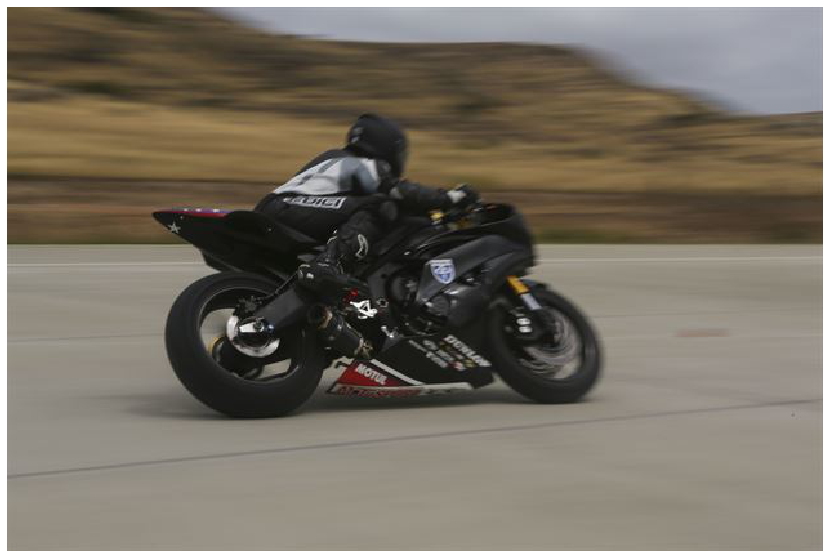

In [915]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

annFile='COCO_file.json'
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


catIds = coco.getCatIds(catNms=['bike','motorbike']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [1]) #<<<<<<<<<<<< Change the number for different test images
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)

I = io.imread(img['file_name'])
h, w, c = I.shape
print(h)
print(w)
plt.axis('off')
plt.imshow(I)
plt.show()

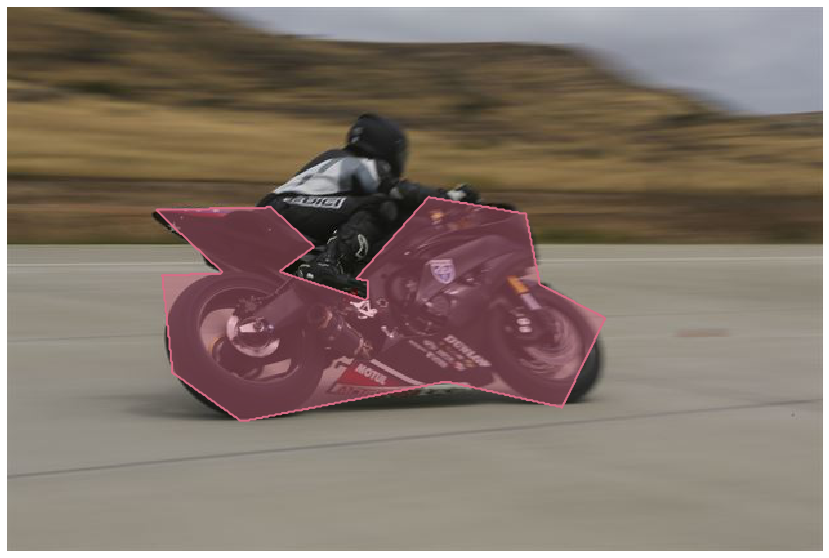

In [916]:
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)


## EXPERIMENTS:  to lower the  numbers of seg values (Don't run)

In [472]:
A=np.array(annotation["segmentation"][0])

tol = 2

'''unique_tol = A[~(np.triu(np.abs(A[:,None] - A) <= tol,1)).any(0)]
unique_tol'''
uniq_seg = np.unique(np.floor(tol*A)/tol)
indexes = np.unique(np.floor(tol*A)/tol, return_index=True)[1]
values = [A[index] for index in sorted(indexes)]
#annotation["segmentation"][0] = values

## Print and show the segmentation

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


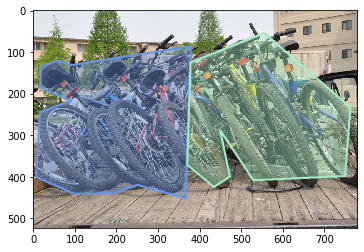

In [537]:
import pycocotools.coco as coco
from pycocotools.coco import COCO
import cv2

for annotation in annotations:
    with open('data.json', 'w') as json_file:
        json.dump(annotation, json_file)
    coco=COCO('data.json')
    I = io.imread('./Downloads/multi-orig.jpeg')

    #I = cv2.resize(I,(300, 225))

    plt.imshow(I)
    coco.showAnns([annotation])

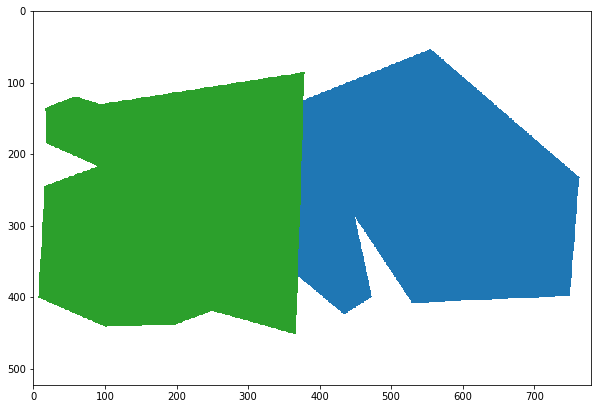

In [228]:
from skimage import io
from skimage.viewer import ImageViewer
import matplotlib.pyplot as plt
from skimage.color import rgb2gray


a = io.imread(base64.decodebytes(img_data), plugin='imageio')
grayscale = rgb2gray(a)
grayscale[grayscale > 0] = 1
plt.imshow(a)
plt.show()